In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import random
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.is_available())
torch.cuda.set_device(0)

True


In [3]:
# Define a convolutional block
# A single layer of convolution if shortcut == False, and...
# Two layers of convolution and a residual convolution otherwise.

class ConvBlock(nn.Module):
    
    # midChannels will be of no use if shortcut == False
    def __init__(self, inChannels, midChannels, outChannels, 
                 kernelSize, stride = 1, padding = 0, bias = True, shortcut = False):
        super(ConvBlock, self).__init__()
        if shortcut is False:
            self.left = nn.Sequential(
                nn.Conv2d(inChannels, outChannels, 
                          kernelSize, stride, padding, bias),
                nn.BatchNorm2d(outChannels)
            )
            self.right = None
        else:
            self.left = nn.Sequential(
                nn.Conv2d(inChannels, midChannels, 
                          kernelSize, stride, padding, bias),
                nn.BatchNorm2d(midChannels),
                nn.ReLU(inplace = True),
                nn.Conv2d(midChannels, outChannels, 
                          kernelSize, stride, padding, bias),
                nn.BatchNorm2d(outChannels)
            )
            self.right = nn.Sequential(
                nn.Conv2d(inChannels, outChannels, 
                          kernelSize, stride, padding, bias),
                nn.BatchNorm2d(outChannels)
            )
        
    def forward(self, input):
        out = self.left(input)
        if self.right is not None:
            out += self.right(input)
        return F.relu(out)
    

In [4]:
# Define a fully connected block
# A single layer if shortcut == False, and...
# Two layers and a residual layer otherwise.

class FCBlock(nn.Module):
    
    # midChannels will be of no use if shortcut == False
    def __init__(self, inNodes, midNodes, outNodes, shortcut = False):
        super(FCBlock, self).__init__()
        if shortcut is False:
            self.left = nn.Sequential(
                nn.Linear(inNodes, outNodes)
            )
            self.right = None
        else:
            self.left = nn.Sequential(
                nn.Linear(inNodes, midNodes),
                nn.ReLU(inplace = True),
                nn.Linear(midNodes, outNodes)
            )
            self.right = nn.Sequential(
                nn.Linear(inNodes, outNodes)
            )
            
    def forward(self, input):
        out = self.left(input)
        if self.right is not None:
            out += self.right(input)
        return F.relu(out)
        

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [6]:
class ChunkSampler(sampler.Sampler):
    """Samples elements randomly from the given index list. 
    """
    def __init__(self, index_list):
        self.index = index_list
        self.length = len(index_list)

    def __iter__(self):
        return iter(self.index)

    def __len__(self):
        return self.length


In [7]:
gpuDtype = torch.cuda.FloatTensor

trainList = []
valList = []
def checkAccuracy(model, trainLoader, valLoader):
    numCorrect = 0
    numSamples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in trainLoader:
        with torch.no_grad():
            xVar = Variable(x.type(gpuDtype))
            scores = model(xVar)
            _, preds = scores.data.cpu().max(1)
            numCorrect += (preds == y).sum()
            numSamples += preds.size(0)
    acc = float(numCorrect) / numSamples
    trainList.append(acc)
    print('Train: %d / %d correct (%.2f%%)' % (numCorrect, numSamples, 100 * acc))
    
    numCorrect = 0
    numSamples = 0
    for x, y in valLoader:
        with torch.no_grad():
            xVar = Variable(x.type(gpuDtype))
            scores = model(xVar)
            _, preds = scores.data.cpu().max(1)
            numCorrect += (preds == y).sum()
            numSamples += preds.size(0)
    acc = float(numCorrect) / numSamples
    valList.append(acc)
    print('Val: %d / %d correct (%.2f%%)' % (numCorrect, numSamples, 100 * acc))
    
def train(model, lossFunc, optimizer, numEpochs = 1, lpReg = {}, 
          printEvery = 100, checkEveryEpoch = True):
    for epoch in range(numEpochs):
        print('Starting epoch %d / %d' % (epoch + 1, numEpochs))
        model.train()
        for t, (x, y) in enumerate(trainLoader):
            xVar = Variable(x.type(gpuDtype))
            yVar = Variable(y.type(gpuDtype).long())
            scores = model(xVar)            
            loss = lossFunc(scores, yVar)
            
            for name, param in model.named_parameters():
                for (p, lamb) in lpReg.items():
                    loss += lamb * torch.norm(param, int(p))
            
            if printEvery > 0 and (t + 1) % printEvery == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.item()))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if checkEveryEpoch:
            checkAccuracy(model, trainLoader, valLoader)

In [8]:
def showFigure(markLast = 0):
    fig = plt.figure(figsize = (15, 8))
    NUM_EPOCHS = len(trainList)
    pt, = plt.plot(range(1, NUM_EPOCHS + 1), trainList, c = 'red')
    pv, = plt.plot(range(1, NUM_EPOCHS + 1), valList, c = 'blue')
    for i in range(NUM_EPOCHS):
        plt.text(i + 1, trainList[i] + ((i % 2) - 0.8) * 0.005, '%.4f' % trainList[i], ha = 'center', va = 'bottom', fontsize = 9)
        plt.text(i + 1, valList[i] + ((i % 2) - 0.8) * 0.005, '%.4f' % valList[i], ha = 'center', va = 'bottom', fontsize = 9)
        if markLast > 0 and (i == NUM_EPOCHS - markLast or i == NUM_EPOCHS - 1):
            plt.axvline(x = i + 1, color = 'green', linewidth = 2)
        else:
            plt.axvline(x = i + 1, color = 'lightgrey', linewidth = 1, linestyle = '--')
    plt.xticks(range(1, NUM_EPOCHS + 1))
    plt.legend([pt, pv], ['Train', 'Val'], loc = 'upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

def showDeltaAcc(numEpochs):
    deltaAcc = 0.0
    totalEpochs = len(trainList)
    for i in range(totalEpochs - numEpochs, totalEpochs):
        deltaAcc += trainList[i] - valList[i]
    deltaAcc /= 10
    print('Delta accuracy for the last 10 epochs is: %.4f' % deltaAcc)

In [9]:
class ResNet(nn.Module):
    
    def __init__(self):
        super(ResNet, self).__init__()
        
        self.blocks = nn.Sequential(
            ConvBlock(inChannels = 3, midChannels = 6, outChannels = 12, 
                      kernelSize = 3, padding = 1, shortcut = True),
            nn.MaxPool2d(kernel_size = 2),
            ConvBlock(inChannels = 12, midChannels = 24, outChannels = 48, 
                      kernelSize = 3, padding = 1, shortcut = True),
            nn.MaxPool2d(kernel_size = 2),
            
            Flatten(),
            
            FCBlock(inNodes = 3072, midNodes = 1024, outNodes = 512, 
                    shortcut = True),
            FCBlock(inNodes = 512, midNodes = 128, outNodes = 32, 
                    shortcut = True),
            FCBlock(inNodes = 32, midNodes = 0, outNodes = 10, 
                    shortcut = False)
            
        )
    
    def forward(self, input):
        out = self.blocks(input)
        return out

In [10]:
DATASET_SIZE = 50000

numTrain = 20000
numVal = 1000

#random.seed(666)
index_all = random.sample(range(DATASET_SIZE), numTrain + numVal)
index_train = index_all[ : numTrain]
index_val = index_all[numTrain : ]

trainData = datasets.CIFAR10('./data', train = True,
                           transform = transforms.ToTensor())
trainLoader = DataLoader(trainData, batch_size = 64, 
                              sampler = ChunkSampler(index_train))

valData = datasets.CIFAR10('./data', train = True,
                           transform = transforms.ToTensor())
valLoader = DataLoader(valData, batch_size = 64, 
                            sampler = ChunkSampler(index_val))

testData = datasets.CIFAR10('./data', train = False,
                          transform = transforms.ToTensor())
testLoader = DataLoader(testData, batch_size = 64)

Starting epoch 1 / 6
Train: 6006 / 20000 correct (30.03%)
Val: 306 / 1000 correct (30.60%)
Starting epoch 2 / 6
Train: 8259 / 20000 correct (41.30%)
Val: 438 / 1000 correct (43.80%)
Starting epoch 3 / 6
Train: 9510 / 20000 correct (47.55%)
Val: 486 / 1000 correct (48.60%)
Starting epoch 4 / 6
Train: 10779 / 20000 correct (53.90%)
Val: 545 / 1000 correct (54.50%)
Starting epoch 5 / 6
Train: 11380 / 20000 correct (56.90%)
Val: 580 / 1000 correct (58.00%)
Starting epoch 6 / 6
Train: 11901 / 20000 correct (59.50%)
Val: 599 / 1000 correct (59.90%)
Delta accuracy for the last 10 epochs is: -0.0021


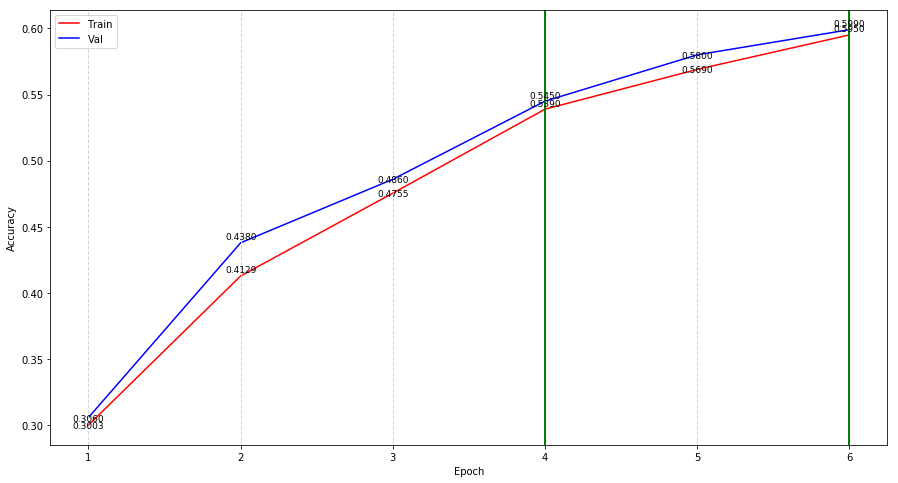

In [11]:
#TORCH_SEED = 666
#torch.manual_seed(TORCH_SEED)
#torch.cuda.manual_seed(TORCH_SEED)

model = ResNet().type(gpuDtype)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

lpReg = {'1': 5e-4}
train(model, criterion, optimizer, numEpochs = 50, lpReg = lpReg,
      printEvery = 0, checkEveryEpoch = True)

showDeltaAcc(numEpochs = 10)
showFigure(markLast = 10)